<a href="https://colab.research.google.com/github/JinLeeGG/DataAnalysis_Starbucks/blob/main/6_Location_strategy_for_a_coffee_franchise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://ryuzyproject.tistory.com/65?category=1106451

# 1. 스타벅스 옆엔 이디야와 올리브영이 있다?
https://kid.chosun.com/site/data/html_dir/2022/06/02/2022060202963.html

# 2. 스타벅스 정보 크롤링

```
import re # 정규표현식용
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup


def fetch_starbucks():
    starbucks_url = 'https://www.starbucks.co.kr/index.do'
    driver = webdriver.Chrome()
    driver.maximize_window() # 화면 최대화
    driver.get(starbucks_url)
    time.sleep(1)

    # 마우스를 조정하면서 고난이도의 태스크들을 사용하게 해주는것이 ActionChains이다.
    action = ActionChains(driver)
    
    # 첫 태그 (스타벅스 사이트의 Store 의 위치)]
    # By.CSS_Selector, 웹사이트의 store html 코드의 copy -> copy selector
    first_tag = driver.find_element(By.CSS_SELECTOR, "#gnb > div > nav > div > ul > li.gnb_nav03 > h2 > a")
    
    # 두 번째 태그 (Store >> 지역검색의 위치)
    second_tag = driver.find_element(By.CSS_SELECTOR, "#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a")

    # element에 마우스를 얹어주고 >> 다음 태그에 얹어주고 >> 클릭을 한다.
    # perform()을 해야 실행을 시켜준다.
    action.move_to_element(first_tag).move_to_element(second_tag).click().perform()

    # 서울 태그를 눌러줄때까지 대기
    # 이 내용을 클릭할수 있을때까지 드라이버가 최대 10초를 기다린다.
    # 만약 그 전에 누를 수 있게 되면 클릭한다.
    seoul_tag = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.CSS_SELECTOR, "#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(1) > a")
        )
    )
    # "서울" 태그를 클릭한다.
    seoul_tag.click()

    # 드라이버는 최대 5초동안 class "set_gugun_cd_btn"을 찾을때까지 기다린다.
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((
        By.CLASS_NAME, 'set_gugun_cd_btn')))
    
    # set_gugun_cd_btn 의 element를 가져온다.
    gu_elements = driver.find_elements(By.CLASS_NAME, 'set_gugun_cd_btn')

    # "전체" 태그를 찾을때까지 최대 5초동안 기다린다.
    # 만약 그 전에 누를 수 있게 되면 클릭한다.
    WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable(
            (By.CSS_SELECTOR, "#mCSB_2_container > ul > li:nth-child(1) > a")
        )
    )
    # "전체" 태그 클릭
    gu_elements[0].click()

    # 5초동안 쉬기
    time.sleep(5)

    # 각 지점 박스에 있는 내용을 가져오기
    # "quickResultLstCon" 박스가 나오면 크롤링을 진행한다.
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'quickResultLstCon')))

    # parsing information
    req = driver.page_source
    # parser 이름을 지정해준다.
    soup = BeautifulSoup(req, 'html.parser')
    
    # ul 전체 데이터에서 li 태그가 한칸한칸을 뜻한다.
    # 그 한칸한칸을 가져온다. (각 매장)
    stores = soup.find('ul', 'quickSearchResultBoxSidoGugun').find_all('li')


    # 각 데이터를 넣어줄 리스트를 만든다.
    store_list = []
    addr_list = []
    lat_list = []
    lng_list = []



    # 한칸씩 파싱을 해준다.
    for store in stores:
        # strong 안에 매장 이름이 들어가있다.
        store_name = store.find('strong').text
        # 각 매장의 주소를 가져온다. (p tag)
        # 하지만 전화번호까지 같이 붙어있다. 따라서 정규표현식을 사용해서 분리한다.
        store_addr = store.find('p').text
        # 문자열을 검사
        # 정수형, "4자리숫자-4자리숫자 끝($)" 패턴을 찾자.
        # 찾았으면 ''로 바꾼다 (지워주기)
        # 끝에는 공백을 지워준다.
        store_addr = re.sub(r'\d{4}-\d{4}$', '', store_addr).strip()
        # store에서 data-lat 속성을 찾는다 (위도).
        store_lat = store['data-lat']
        # store에서 data-long 속성을 찾는다 (경도).
        store_lng = store['data-long']

        # 각 데이터를 리스트에 넣는다.
        store_list.append(store_name)
        addr_list.append(store_addr)
        lat_list.append(store_lat)
        lng_list.append(store_lng)

    # 데이터 리스트로 데이터프레임을 만든다.
    df = pd.DataFrame({
        'store' : store_list,
        'addr' : addr_list,
        'lat' : lat_list,
        'lng' : lng_list
    })

    time.sleep(3)
    #driver 종료
    driver.quit()
    # dataframe return
    return df

starbucks_df = fetch_starbucks()
# csv 파일로 만들기
starbucks_df.to_csv('starbucks_seoul.csv', index=False, encoding='utf-8-sig')
print('데이터가 starbucks_seoul.csv 파일로 저장되었습니다.')

```

# 3. 데이터 전처리

In [28]:
import pandas as pd

In [29]:
df_starbucks = pd.read_csv('/content/drive/MyDrive/Python_Computer Vision With AI/3. Data Analysis/data/starbucks_seoul.csv')
df_starbucks # 데이터가 잘 가져와진다.

,store,addr,lat,lng
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...
643,상봉역,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
644,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
645,망우동,서울특별시 중랑구 망우로 407 (망우동),37.599508,127.097539
646,양원역,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360


In [30]:
# 축에 따라서 column 이름 재설정
# index명 재설정
df_starbucks = df_starbucks.set_axis(['지점명', '지점주소', '지점위도', '지점경도'], axis=1).reset_index(drop=True)
df_starbucks

,지점명,지점주소,지점위도,지점경도
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...
643,상봉역,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
644,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
645,망우동,서울특별시 중랑구 망우로 407 (망우동),37.599508,127.097539
646,양원역,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360


### 공공데이터포털
https://www.data.go.kr/index.do

### 소상공인시장진흥공단_상가(상권)정보
https://www.data.go.kr/data/15083033/fileData.do
- csv 파일을 다운 후 서울 데이터를 가져온다.


In [31]:
# low_memory=False 메모리를 많이 사용하고 안정적으로 불러온다.
df = pd.read_csv('/content/drive/MyDrive/Python_Computer Vision With AI/3. Data Analysis/data/소상공인시장진흥공단_상가(상권)정보_서울_202503.csv', low_memory=False)
df

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,MA010120220800000033,부동산임대김은숙,NaN,I2,음식,I212,비알코올,I21201,카페,I56229,...,1111014000100280021026727,NaN,서울특별시 종로구 삼청로 122-1,110230,3053,NaN,NaN,NaN,126.981840,37.586250
1,MA010120220800000036,한국황토건축연구소,NaN,L1,부동산,L102,부동산 서비스,L10203,부동산 중개/대리업,L68221,...,1165010800113080025020133,강남오피스텔,서울특별시 서초구 서초대로73길 40,137856,6612,NaN,11,NaN,127.024563,37.500924
2,MA010120220800000077,소망공인중개사사무소,NaN,L1,부동산,L102,부동산 서비스,L10203,부동산 중개/대리업,L68221,...,1120012200100040011000899,NaN,서울특별시 성동구 용답중앙15길 18,133847,4805,NaN,1,NaN,127.054262,37.564786
3,MA010120220800000084,고향집,NaN,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,1111015400100800000000001,NaN,서울특별시 종로구 돈화문로4길 30,110430,3193,NaN,NaN,NaN,126.993820,37.570025
4,MA010120220800000090,보석나라,NaN,G2,소매,G217,시계·귀금속 소매,G21701,시계/귀금속 소매업,G47830,...,1153010700103590008007958,NaN,서울특별시 구로구 개봉로3길 23,152815,8353,NaN,1,NaN,126.855046,37.486242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540512,MA0101202502A0113097,동양에이전시,NaN,M1,과학·기술,M105,광고,M10504,광고물 설계/제작업,M71393,...,1144012000103470021024741,기린빌딩,서울특별시 마포구 어울마당로 130,121837,4053,NaN,3,NaN,126.924524,37.555810
540513,MA0101202502A0113099,서관면옥,NaN,M1,과학·기술,M107,본사·경영 컨설팅,M10703,경영 컨설팅업,M71531,...,1114012400100540000023233,신세계백화점,서울특별시 중구 퇴계로 77,100011,4530,NaN,14,NaN,126.980771,37.560355
540514,MA0101202502A0113654,아리가,NaN,I2,음식,I203,일식,I20301,일식 회/초밥,I56122,...,1165010800113600031023092,정진빌딩,서울특별시 서초구 강남대로41길 15-19,137863,6730,NaN,2,NaN,127.032179,37.486407
540515,MA0101202502A0113657,백압관,NaN,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,1168010400100530003017865,NaN,서울특별시 강남구 학동로97길 74,135952,6071,NaN,1,NaN,127.053113,37.524197


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540517 entries, 0 to 540516
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     540517 non-null  object 
 1   상호명        540517 non-null  object 
 2   지점명        48544 non-null   object 
 3   상권업종대분류코드  540517 non-null  object 
 4   상권업종대분류명   540517 non-null  object 
 5   상권업종중분류코드  540517 non-null  object 
 6   상권업종중분류명   540517 non-null  object 
 7   상권업종소분류코드  540517 non-null  object 
 8   상권업종소분류명   540517 non-null  object 
 9   표준산업분류코드   540317 non-null  object 
 10  표준산업분류명    540317 non-null  object 
 11  시도코드       540517 non-null  int64  
 12  시도명        540517 non-null  object 
 13  시군구코드      540517 non-null  int64  
 14  시군구명       540517 non-null  object 
 15  행정동코드      540517 non-null  int64  
 16  행정동명       540517 non-null  object 
 17  법정동코드      540517 non-null  int64  
 18  법정동명       540517 non-null  object 
 19  지번코드       540517 non-n

In [33]:
# 스타벅스 근처에 있을법한 브랜드
shop = ['이디야', '이디아', '올리브영', '컴포즈커피', '빽다방', '백다방', '메가커피', '메가엠지씨']

In [34]:
# 상호명이 null값제외 '메가커피'를 찾아라
df[df['상호명'].str.contains('메가커피', case=False, na=False)]

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
11397,MA010120220800186190,식빵은여기메가커피,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010200100030000000001,잠실동잠실역지하도상가,서울특별시 송파구 올림픽로 265,138934,5510,NaN,NaN,NaN,127.100668,37.513453
34455,MA010120220800505619,메가커피우,장산점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1150010600107230008009245,좌,서울특별시 강서구 강서로45길 6,157835,7639,NaN,1,NaN,126.835813,37.548097
79183,MA010120220802241927,메가커피,마곡점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1150010500107570003000001,마곡나루역보타닉비즈타워,서울특별시 강서구 마곡중앙5로1길 20,157805,7788,NaN,1,NaN,126.826712,37.568672
82047,MA010120220802678209,메가커피문정,아이파크점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010800100000000000002,문정아이파크,서울특별시 송파구 법원로4길 6,138888,5855,NaN,NaN,NaN,127.122108,37.482312
89278,MA010120220803145703,메가커피현대,시장점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1162010100104640002033874,NaN,서울특별시 관악구 은천로 113,151825,8729,NaN,1,NaN,126.947863,37.486959
95297,MA010120220803387874,메가커피신곡,시장점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1147010300105370008011026,NaN,서울특별시 양천구 신월로 175,158840,8030,NaN,1,NaN,126.842540,37.518842
141402,MA010120220804156243,메가커피신도림역점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1153010100103370000000004,신도림푸르지오1차,서울특별시 구로구 경인로 661,152748,8208,NaN,NaN,NaN,126.887767,37.509532
141793,MA010120220804149613,메가커피,장안점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1123010600103660001016482,풍양빌딩,서울특별시 동대문구 장한로 116,130840,2639,NaN,1,NaN,127.071053,37.570742
166339,MA010120220804461630,메가커피지하도점,강남역,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010100108210001000001,강남역지하도상가,서울특별시 강남구 테헤란로 101,135933,6134,NaN,NaN,NaN,127.028034,37.498662
177125,MA010120220804968967,메가커피잠실레이크,팰리스점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010600100220017000001,잠실레이크타워,서울특별시 송파구 석촌호수로 140,138837,5600,NaN,1,NaN,127.092505,37.507018


In [35]:
# 상호명이 null값제외 '메가엠지씨'를 찾아라
df[df['상호명'].str.contains('메가엠지씨', case=False, na=False)]

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
5212,MA010120220800062311,메가엠지씨커피논현아크로힐스점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010800102760000026382,아크로힐스논현,서울특별시 강남구 언주로 604,135833,6102,NaN,1,NaN,127.038399,37.509498
6045,MA010120220800090900,메가엠지씨커피천왕이펜하우스점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1153011100100270000000029,천왕이펜하우스4단지,서울특별시 구로구 천왕로 29,152130,8364,NaN,1,NaN,126.838493,37.480877
7002,MA010120220800105068,메가엠지씨커피신월,사거리점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1147010300101660003011420,NaN,서울특별시 양천구 남부순환로40길 3,158829,7910,NaN,NaN,NaN,126.828318,37.535040
34918,MA010120220800524873,메가엠지씨커피미아,롯데점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1130510100100720005028796,NaN,서울특별시 강북구 도봉로10길 38,142804,1216,NaN,1,NaN,127.031034,37.614376
43667,MA010120220800655475,메가엠지씨커피미아현대점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1129013400105170014024754,NaN,서울특별시 성북구 동소문로 309,136800,2730,NaN,1,NaN,127.028585,37.607719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536196,MA0106202305A0036963,메가엠지씨커피석촌,한솔점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010500102850004009886,NaN,서울특별시 송파구 백제고분로 354,138847,5684,NaN,1,NaN,127.105620,37.504267
537112,MA0106202212A0036884,메가엠지씨커피신논현역점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010800101990005009372,NaN,서울특별시 강남구 강남대로 480,135827,6120,NaN,NaN,NaN,127.024565,37.505294
537189,MA0106202306A0036928,메가엠지씨커피역삼GFC점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010100107380009028033,NaN,서울특별시 강남구 논현로 429,135924,6237,NaN,2,NaN,127.037421,37.499137
539813,MA0101202502A0100676,메가엠지씨커피래미안라그란데점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1123011000102570042002921,래미안라그란데,서울특별시 동대문구 이문로35길 12,130829,2404,NaN,NaN,NaN,127.060233,37.600084


In [36]:
# 상호명이 null값제외 '메가MGC'를 찾아라
df[df['상호명'].str.contains('메가MGC', case=False, na=False)]

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
295794,MA010120220812507366,메가MGC커피상암사보이시티점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1144012700115970000000001,사보이시티디엠씨,서울특별시 마포구 월드컵북로54길 17,121835,3924,NaN,1,NaN,126.888542,37.581325
354229,MA0101202210A0058409,메가MGC커피답십리초점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1123010500102680004023189,대로변,서울특별시 동대문구 전농로 35,130802,2600,NaN,1,NaN,127.056789,37.568245
360335,MA0101202301A0008377,메가MGC커피망원역점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1144012300103760007013676,NaN,서울특별시 마포구 동교로9길 49,121820,4012,NaN,1,NaN,126.909246,37.555835
375110,MA0101202305A0068406,메가MGC커피서강대점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1144011100100810077007762,NaN,서울특별시 마포구 백범로 34,121854,4109,NaN,1,NaN,126.937350,37.551700
395939,MA0101202308A0015888,메가MGC커피구로대륭포스트,2차점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1153010200101820013022975,대륭포스트타워2차,서울특별시 구로구 디지털로 306,152790,8378,NaN,1,NaN,126.897334,37.485926
396798,MA0101202308A0003831,메가MGC커피독산대륭20차점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1154510100106910000017244,대륭테크노타운20차,서울특별시 금천구 가산디지털1로 5,153803,8594,NaN,1,NaN,126.886712,37.466742
418391,MA0101202311A0019637,메가MGC커피,암사점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1174010700104470025015195,NaN,서울특별시 강동구 고덕로 95,134855,5237,NaN,1,NaN,127.135841,37.554927
512400,MA0101202502A0042836,메가MGC커피회현SK리더스뷰점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1114012100102060000000001,남산에스케이리더스뷰,서울특별시 중구 퇴계로 72,100051,4632,NaN,NaN,NaN,126.980601,37.559121
535207,MA0106202304A0036891,앤하우스메가MGC커피,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010500101590009016086,코엑스,서울특별시 강남구 영동대로 513,135525,6164,NaN,1,NaN,127.059155,37.511832
536158,MA0106202302A0121990,메가MGC커피_오더_1,NaN,G2,소매,G212,기타 생활용품 소매,G21202,주방/가정용품 소매업,G47599,...,1114011700100450000022756,대한서울상공회의소,서울특별시 중구 세종대로 39,100743,4513,NaN,7,NaN,126.973776,37.560714


In [37]:
# 메가커피, 메가MGC, 메가엠지씨 한번에 찾기
df[df['상호명'].str.contains('메가MGC|메가커피|메가엠지씨', case=False, na=False)]

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
5212,MA010120220800062311,메가엠지씨커피논현아크로힐스점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010800102760000026382,아크로힐스논현,서울특별시 강남구 언주로 604,135833,6102,NaN,1,NaN,127.038399,37.509498
6045,MA010120220800090900,메가엠지씨커피천왕이펜하우스점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1153011100100270000000029,천왕이펜하우스4단지,서울특별시 구로구 천왕로 29,152130,8364,NaN,1,NaN,126.838493,37.480877
7002,MA010120220800105068,메가엠지씨커피신월,사거리점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1147010300101660003011420,NaN,서울특별시 양천구 남부순환로40길 3,158829,7910,NaN,NaN,NaN,126.828318,37.535040
11397,MA010120220800186190,식빵은여기메가커피,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010200100030000000001,잠실동잠실역지하도상가,서울특별시 송파구 올림픽로 265,138934,5510,NaN,NaN,NaN,127.100668,37.513453
34455,MA010120220800505619,메가커피우,장산점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1150010600107230008009245,좌,서울특별시 강서구 강서로45길 6,157835,7639,NaN,1,NaN,126.835813,37.548097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536196,MA0106202305A0036963,메가엠지씨커피석촌,한솔점,I2,음식,I212,비알코올,I21201,카페,I56221,...,1171010500102850004009886,NaN,서울특별시 송파구 백제고분로 354,138847,5684,NaN,1,NaN,127.105620,37.504267
537112,MA0106202212A0036884,메가엠지씨커피신논현역점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010800101990005009372,NaN,서울특별시 강남구 강남대로 480,135827,6120,NaN,NaN,NaN,127.024565,37.505294
537189,MA0106202306A0036928,메가엠지씨커피역삼GFC점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1168010100107380009028033,NaN,서울특별시 강남구 논현로 429,135924,6237,NaN,2,NaN,127.037421,37.499137
539813,MA0101202502A0100676,메가엠지씨커피래미안라그란데점,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,1123011000102570042002921,래미안라그란데,서울특별시 동대문구 이문로35길 12,130829,2404,NaN,NaN,NaN,127.060233,37.600084


In [38]:
# df 카피
df_shop = df.copy()

# shop = ['이디야', '올리브영', '컴포즈커피', '빽다방', '메가커피', '메가엠지씨']
# 상호명에서 shop에 있는 내용을 | 로 join 시킨다.
# (이디야|올리브영|컴포즈커피|다방|메가커피|메가엠지씨)
# extract에다가 넣으면 특정 문자열을 포함하고 있으면 그 문자열을 반환시킨다.
# 만약 포함하고 있지 않으면 NaN을 반환시킨다.
df_shop['상호명'] = df_shop['상호명'].str.extract('({})'.format('|'.join(shop)))

df_shop['상호명']

,상호명
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
540512,NaN
540513,NaN
540514,NaN
540515,NaN


In [39]:
# NaN 삭제
# 0, 1, 14, 37, 38 만 남기기
# 상가 업소번호, 상호명, 시군구명, 위도, 경도
# 인덱스 재정렬
df_shop = df_shop.dropna(subset=['상호명']).iloc[:, [0, 1, 14, 37, 38]].reset_index(drop=True)
df_shop

,상가업소번호,상호명,시군구명,경도,위도
0,MA010120220800024620,이디야,종로구,127.003181,37.582089
1,MA010120220800021713,컴포즈커피,종로구,127.015995,37.574051
2,MA010120220800026176,이디야,종로구,126.956322,37.601245
3,MA010120220800038013,이디야,종로구,126.991533,37.570096
4,MA010120220800033480,이디야,종로구,126.986745,37.568781
...,...,...,...,...,...
2331,MA0106202201A0056378,이디야,영등포구,126.923409,37.528635
2332,MA0106202201A0056379,이디야,중구,126.986564,37.566492
2333,MA0106202201A0056381,이디야,강남구,127.048190,37.503773
2334,MA0106202201A0056383,이디야,강남구,127.033119,37.514996


In [40]:
# 메가커피 상호명 통일화
df_shop['상호명'] = df_shop['상호명'].str.replace('메가엠지씨', '메가커피', regex=False)
df_shop['상호명'] = df_shop['상호명'].str.replace('메가MGC', '메가커피', regex=False)
df_shop['상호명'] = df_shop['상호명'].str.replace('이디아', '이디야', regex=False)
df_shop['상호명'] = df_shop['상호명'].str.replace('백다방', '빽다방', regex=False)

In [41]:
# 다 메가커피로 바뀌었기 때문에 없다.
df_shop[df_shop['상호명'].str.contains('메가엠지씨', na=False)]

,상가업소번호,상호명,시군구명,경도,위도


In [42]:
print(df_shop.shape) # ['이디야', '올리브영', '컴포즈커피', '다방', '메가커피']
print(df_starbucks.shape) # 스타벅스

(2336, 5)
(648, 4)


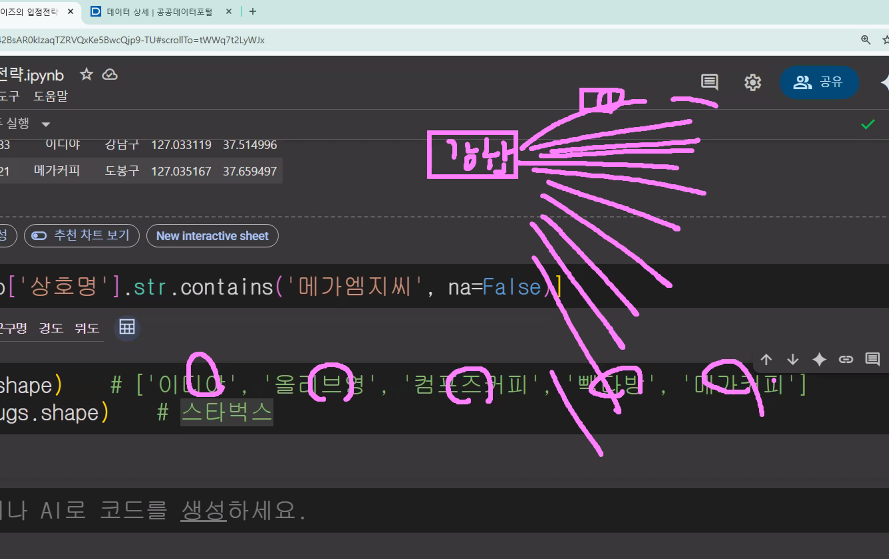

- 강남 근처에 있는 모든 매장을 뽑은다음 가장 작은 거리에 있는 매장들을 비교한다.

In [43]:
df_cross = df_shop.merge(df_starbucks, how='cross')
df_cross

,상가업소번호,상호명,시군구명,경도,위도,지점명,지점주소,지점위도,지점경도
0,MA010120220800024620,이디야,종로구,127.003181,37.582089,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,MA010120220800024620,이디야,종로구,127.003181,37.582089,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,MA010120220800024620,이디야,종로구,127.003181,37.582089,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,MA010120220800024620,이디야,종로구,127.003181,37.582089,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,MA010120220800024620,이디야,종로구,127.003181,37.582089,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...,...,...,...,...,...
1513723,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,상봉역,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
1513724,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
1513725,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,망우동,서울특별시 중랑구 망우로 407 (망우동),37.599508,127.097539
1513726,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,양원역,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360


# 4. 하버사인 공식
Haversine 공식은 구체(구면) 위의 두 점(위도와 경도로 표시됨) 사이의 최단 거리(대원 거리, great-circle distance)를 계산하는 방법입니다. 이 공식은 GPS 좌표(위도와 경도)를 활용하여 지구 표면 위의 거리 계산에 널리 사용됩니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FSrWGW%2FbtsLpNU6kSG%2FAAAAAAAAAAAAAAAAAAAAACWyPfRAMbpe0b_v6ut8rDPwdQDwSdWFmpo2ovU3Wj0f%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1751295599%26allow_ip%3D%26allow_referer%3D%26signature%3DlIv1aFKvpoZg8stXKdFR131fXvw%253D'>

https://aliencoder.tistory.com/32

- 더 정확하게 만들고싶을경우 (골목골목까지)

In [44]:
!pip install haversine

In [45]:
from haversine import haversine

In [46]:
# 스타벅스와의 거리값 계산
df_cross['거리'] = df_cross.apply(lambda x: haversine([x['위도'], x['경도']], [x['지점위도'], x['지점경도']], unit='m'), axis=1)
df_cross

,상가업소번호,상호명,시군구명,경도,위도,지점명,지점주소,지점위도,지점경도,거리
0,MA010120220800024620,이디야,종로구,127.003181,37.582089,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,9669.246029
1,MA010120220800024620,이디야,종로구,127.003181,37.582089,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,8170.467737
2,MA010120220800024620,이디야,종로구,127.003181,37.582089,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,7732.950240
3,MA010120220800024620,이디야,종로구,127.003181,37.582089,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,9514.913964
4,MA010120220800024620,이디야,종로구,127.003181,37.582089,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,11041.982974
...,...,...,...,...,...,...,...,...,...,...
1513723,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,상봉역,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,8299.147898
1513724,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,6116.326172
1513725,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,망우동,서울특별시 중랑구 망우로 407 (망우동),37.599508,127.097539,8640.842783
1513726,MA0101202502A0103021,메가커피,도봉구,127.035167,37.659497,양원역,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,8592.394694


In [47]:
# 스벅이랑 개별 매장별 가장 적게 떨어저있는 위치
# 상가업소번호가 같은걸 상호명으로 묶어주고 그 거리중 최소값을 구한다.
df_dis = df_cross.groupby(['상가업소번호', '상호명'])['거리'].min().reset_index()
df_dis

,상가업소번호,상호명,거리
0,MA010120220800021713,컴포즈커피,692.058445
1,MA010120220800024620,이디야,95.740366
2,MA010120220800026176,이디야,1115.073437
3,MA010120220800033480,이디야,81.912918
4,MA010120220800033806,이디야,352.787720
...,...,...,...
2331,MA0106202501A2292341,올리브영,7.329813
2332,MA0106202501A2304002,이디야,215.319431
2333,MA0106202502A2284422,올리브영,400.235185
2334,MA0106202502A2284581,올리브영,139.507587


In [48]:
# 각 프랜차이즈 별 스타벅스와의 평균 거리
df_dis.groupby('상호명')['거리'].mean()

,거리
상호명,
메가커피,391.856739
빽다방,306.319381
올리브영,216.871522
이디야,386.316013
컴포즈커피,356.386697


In [55]:
# agg(): 다중 집계작업을 간단하게 해주는 함수
df_dis.groupby(['상호명'])['거리'].agg(['mean','count'])

,mean,count
상호명,,
메가커피,391.856739,825
빽다방,306.319381,371
올리브영,216.871522,179
이디야,386.316013,530
컴포즈커피,356.386697,431


In [50]:
!pip install pandasecharts

In [56]:
# 거리를 입력하면 프렌차이즈 별 스타벅스와의 평균거리와 매장개수를 출력하는 함수
def distance(x):
    dis = df_dis['거리'] <= x
    return df_dis[dis].groupby('상호명')['거리'].agg(['mean', 'count'])

distance(100)


,mean,count
상호명,,
메가커피,59.745134,143
빽다방,64.194273,92
올리브영,56.060383,74
이디야,65.037261,92
컴포즈커피,62.717747,86


In [57]:
# 스타벅스와 100m 이내 거리의 프랜차이즈 매장수
df_100 = distance(100).reset_index()
df_100

,상호명,mean,count
0,메가커피,59.745134,143
1,빽다방,64.194273,92
2,올리브영,56.060383,74
3,이디야,65.037261,92
4,컴포즈커피,62.717747,86


In [53]:
import IPython # 이미지를 저장할 때 쓰는 모듈
from pandasecharts import echart # echart를 사용

# 파이 그래프를 그리기.
df_100.echart.pie(x='상호명', y='count', figsize=(600, 400),
                  radius=['20%', '60%'], label_opts={'position':'outer'}, # outer는 조각이 바깥쪽으로 나오게 하는 기능
                  title='커피 프렌차이즈의 입점전략은 과연 스타벅스 옆인가?',
                  legend_opts={'pos_right':'0%', 'orient':'vertical'}, # 오른쪽 설명
                  subtitle='100m 이내 매장수', init_opts={'bg_color': 'white'}).render() # 서브타이틀

IPython.display.HTML(filename='render.html')

In [54]:
from pyecharts.charts import Timeline, Grid

tl = Timeline({'width':'600px', 'height':'400px'})

for i in [1000, 100, 50, 30]:
    df_d = distance(i).reset_index()
    pie1 = df_d.echart.pie(x='상호명', y='count', figsize=(600, 400),
                    radius=['20%', '60%'], label_opts={'position':'outer'},
                    title='커피 프렌차이즈의 입점전략은 과연 스타벅스 옆인가?',
                    legend_opts={'pos_right':'0%', 'orient':'vertical'},
                    subtitle='{}m 이내 매장수'.format(i), init_opts={'bg_color': 'white'})
    tl.add(pie1, '{}m'.format(i)).render()
IPython.display.HTML(filename='render.html')